# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [14]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [15]:
# Fill in the median and maximum number of user_article interactios below

# Group by 'user_id' and count the number of interactions per user
user_interactions = df.groupby('email')['article_id'].count()

# Calculate the median number of interactions
median_val = user_interactions.median()

# Calculate the maximum number of interactions
max_views_by_user = user_interactions.max()

# Print the results
print(f"50% of individuals interact with {median_val} articles or fewer.")
print(f"The maximum number of user-article interactions by any 1 user is {max_views_by_user}.")

50% of individuals interact with 3.0 articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [16]:
# Find and explore duplicate articles

# Step 1: Check for duplicate article_ids
duplicate_articles = df[df.duplicated(subset='article_id', keep=False)]

# Step 2: Count the number of duplicates for each article_id
duplicate_article_counts = duplicate_articles['article_id'].value_counts()

# Step 3: Explore the duplicates
# Display the rows that have duplicate article_ids
print(f"Duplicate articles found: {duplicate_article_counts}")

# Step 4: Show sample duplicates for inspection (if needed)
print(duplicate_articles.head())

Duplicate articles found: 1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
1436.0    481
1271.0    473
1398.0    465
43.0      460
1351.0    457
1393.0    455
1185.0    442
1160.0    433
1354.0    426
1368.0    418
1305.0    413
1338.0    382
1336.0    379
1165.0    372
1172.0    363
151.0     352
1276.0    347
1432.0    340
1430.0    336
1052.0    330
         ... 
1101.0      2
1075.0      2
708.0       2
1244.0      2
1091.0      2
1188.0      2
757.0       2
636.0       2
1069.0      2
1335.0      2
1235.0      2
1135.0      2
1121.0      2
499.0       2
644.0       2
443.0       2
384.0       2
1089.0      2
376.0       2
504.0       2
1203.0      2
947.0       2
1197.0      2
1067.0      2
1251.0      2
586.0       2
1226.0      2
364.0       2
1130.0      2
1227.0      2
Name: article_id, Length: 696, dtype: int64
   article_id                                              title  \
0      1

In [17]:
# Remove duplicate rows based on 'article_id' and keep only the first occurrence
df_content_cleaned = df_content.drop_duplicates(subset='article_id', keep='first')

# Display the cleaned DataFrame
print(df_content_cleaned)

                                               doc_body  \
0     Skip navigation Sign in SearchLoading...\r\n\r...   
1     No Free Hunch Navigation * kaggle.com\r\n\r\n ...   
2     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...   
3     DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...   
4     Skip navigation Sign in SearchLoading...\r\n\r...   
5     Compose is all about immediacy. You want a new...   
6     UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...   
7     Follow Sign in / Sign up 135 8 * Share\r\n * 1...   
8     * Host\r\n * Competitions\r\n * Datasets\r\n *...   
9     THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...   
10    OFFLINE-FIRST IOS APPS WITH SWIFT & PART 1: TH...   
11    Warehousing data from Cloudant to dashDB great...   
12    Skip to main content IBM developerWorks / Deve...   
13    Maureen McElaney Blocked Unblock Follow Follow...   
14    Raj Singh Blocked Unblock Follow Following Dev...   
15    * Home\r\n * Community\r\n * Projects\r\n * Bl... 

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [18]:
# 1. Number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()

# 2. Total number of unique articles on the platform (assuming you have a separate dataset with all articles)
total_articles = df_content_cleaned['article_id'].nunique()

# 3. Number of unique users
unique_users = df['email'].nunique()

# 4. Number of user-article interactions (assuming each row represents one interaction)
user_article_interactions = df.shape[0]

# Display the results
print(f"Number of unique articles with at least one interaction: {unique_articles}")
print(f"Total number of unique articles on the platform: {total_articles}")
print(f"Number of unique users: {unique_users}")
print(f"Number of user-article interactions: {user_article_interactions}")

Number of unique articles with at least one interaction: 714
Total number of unique articles on the platform: 1051
Number of unique users: 5148
Number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [19]:
# 1. Group by 'article_id' and count the number of interactions (views) for each article
article_view_counts = df.groupby('article_id').size()

# 2. Find the article with the most views
max_views = article_view_counts.max()  # The most viewed article was viewed 'max_views' times
most_viewed_article_id = str(article_view_counts.idxmax())  # Get the article_id of the most viewed article

# Ensure the most viewed article_id is formatted as a string with one decimal place
most_viewed_article_id = f"{float(most_viewed_article_id):.1f}"

# Print the results
print(f"The most viewed article is article {most_viewed_article_id} with {max_views} views.")

The most viewed article is article 1429.0 with 937 views.


In [20]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [21]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [22]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles ordered by number of interactions (descending)
    
    '''
    # Group by article_id, count the interactions, and sort by count in descending order
    top_article_counts = df.groupby('article_id').size().sort_values(ascending=False).head(n)
    
    # Get the article titles corresponding to the top article_ids based on interaction count
    top_articles = df[df['article_id'].isin(top_article_counts.index)].drop_duplicates('article_id').sort_values('article_id')['title'].tolist()

    return top_articles # Return the top article titles


def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_article_ids - (list) A list of the top 'n' article ids, ordered by number of interactions (descending)
    
    '''
    # Group by article_id, count the interactions, and sort by count in descending order
    top_article_counts = df.groupby('article_id').size().sort_values(ascending=False).head(n)
    
    # Get the top article ids based on interaction count
    top_article_ids = top_article_counts.index.tolist()

    return top_article_ids # Return the top article ids

In [23]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['analyze energy consumption in buildings', 'apache spark lab, part 1: basic concepts', 'finding optimal locations of new store using decision optimization', 'gosales transactions for logistic regression model', 'healthcare python streaming application demo', 'insights from new york car accident reports', 'predicting churn with the spss random tree algorithm', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'use deep learning for image classification', 'visualize car data with brunel']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [24]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [25]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user-item matrix (pandas DataFrame)
    
    Description:
    Return a matrix with user ids as rows and article ids as columns with 1 values where a user interacted with 
    an article and 0 otherwise
    '''
    # Create the user-item matrix with 1's and 0's using pivot_table
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack(fill_value=0)
    
    # Convert any count greater than 0 to 1 (binary matrix)
    user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)
    
    return user_item # return the user-item matrix

# Call the function to create the matrix
user_item = create_user_item_matrix(df)

In [26]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [27]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    most_similar_users - (list) an ordered list where the closest users (largest dot product users)
                         are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product.
    Returns an ordered list of the most similar users based on this computation.
    '''
    # Compute the dot product for the user with all other users
    user_vector = user_item.loc[user_id].values
    similarity = user_item.dot(user_vector)
    
    # Sort by similarity in descending order
    similarity = similarity.sort_values(ascending=False)
    
    # Get the list of user_ids, excluding the provided user_id
    most_similar_users = similarity.index[similarity.index != user_id].tolist()
    
    return most_similar_users  # Return a list of the users in order from most to least similar

# Example usage
similar_users = find_similar_users(1, user_item)
print(similar_users)
        

[3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041, 49, 3697, 395, 3910, 322, 3622, 242, 4642, 290, 2982, 912, 3540, 98, 754, 3764, 256, 52, 268, 40, 371, 3596, 621, 21, 273, 3637, 5138, 135, 204, 3784, 3775, 1355, 4785, 4932, 4134, 3621, 3651, 3483, 696, 4293, 488, 4892, 3532, 334, 4038, 184, 1897, 619, 765, 2926, 214, 249, 4778, 186, 3141, 4755, 3136, 64, 3740, 54, 4934, 3684, 125, 72, 3856, 4484, 445, 58, 3632, 60, 67, 2790, 5013, 4206, 3024, 4209, 665, 5079, 656, 5140, 4706, 4774, 288, 187, 10, 38, 4471, 4824, 2975, 223, 2981, 3693, 90, 193, 807, 3006, 3169, 195, 409, 211, 87, 235, 330, 3197, 244, 324, 4595, 4933, 2430, 3408, 295, 4883, 4543, 3572, 3578, 3358, 362, 3354, 113, 3353, 111, 1040, 263, 261, 1059, 3485, 170, 379, 4277, 689, 733, 591, 3818, 4404, 69, 2161, 4225, 511, 3949, 3, 28, 3879, 3794, 8, 2903, 3305, 155, 4021, 641, 640, 1271, 3329, 3376, 280, 4037, 639, 3441, 647, 659, 926, 471, 3967, 3500, 1353, 670, 1330, 45, 319, 2423, 312, 4901, 4900, 2908, 304, 26, 168, 11,

In [28]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [29]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Filter the dataframe to get rows with the article_ids and return the title column
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Get the article IDs that the user has interacted with
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str).tolist()

    # Get the corresponding article names
    article_names = get_article_names(article_ids, df)

    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id.
    For each user - finds articles the user hasn't seen before and provides them as recs.
    Does this until m recommendations are found.
    '''
    # Find similar users
    similar_users = find_similar_users(user_id, user_item)
    
    # Get the articles seen by the user
    user_article_ids, _ = get_user_articles(user_id, user_item)
    
    recs = set()  # Store recommendations in a set to avoid duplicates
    
    # Loop through the similar users to find new articles for the target user
    for sim_user in similar_users:
        sim_user_article_ids, _ = get_user_articles(sim_user, user_item)
        
        # Find articles the similar user has seen, but the target user hasn't
        new_recs = set(sim_user_article_ids) - set(user_article_ids)
        
        # Add new recommendations to the set
        recs.update(new_recs)
        
        # If we have enough recommendations, stop
        if len(recs) >= m:
            break
    
    # Return only the top m recommendations
    return list(recs)[:m]

In [30]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['timeseries data analysis of iot events by using jupyter notebook',
 'the nurse assignment problem',
 'using github for project control in dsx',
 'pixieapp for outlier detection',
 'movie recommender system with spark machine learning',
 'modeling energy usage in new york city',
 'pixiedust 1.0 is here! – ibm watson data lab',
 'this week in data science (february 14, 2017)',
 'flightpredict ii: the sequel  – ibm watson data lab',
 'airbnb data for analytics: vancouver listings']

In [31]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [44]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int) the ID of the user we want to find neighbors for
    df - (pandas dataframe) the original dataframe as defined at the top
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
                
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                   neighbor_id - neighbor user_id
                   similarity - measure of the similarity of each user to the provided user_id
                   num_interactions - the number of articles viewed by the user
                   
    Description:
    This function finds the similarity of each user to the input user and sorts users based on 
    similarity and number of interactions.
    '''
    # Calculate the dot product to compute similarity
    user_similarity = user_item.dot(user_item.loc[user_id])
    
    # Get the number of interactions each user has had
    num_interactions = df.groupby('user_id').count()["title"]
    
    # Create a dataframe with similarity and num_interactions
    neighbors_df = pd.DataFrame({
        'neighbor_id': user_similarity.index,
        'similarity': user_similarity.values,
        'num_interactions': num_interactions.values
    })
    
    # Remove the current user from the neighbors_df
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    # Sort the dataframe by similarity and then by number of interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) the ID of the user we want recommendations for
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of article ids recommended for the user
    rec_names - (list) a list of article names recommended for the user
    
    Description:
    This function recommends articles to a user by finding users most similar to them 
    and recommending articles the user has not yet interacted with.
    '''
    # Get the top sorted users based on similarity and number of interactions
    neighbors_df = get_top_sorted_users(user_id)
    
    # Get articles the user has already interacted with
    seen_article_ids, _ = get_user_articles(user_id, user_item)
    
    recs = []
    
    # Loop through the neighbors to get recommendations
    for neighbor_id in neighbors_df['neighbor_id']:
        # Get the articles that the neighbor has seen
        neighbor_article_ids, _ = get_user_articles(neighbor_id, user_item)
        
        # Find articles that the current user has not seen yet
        new_recs = list(set(neighbor_article_ids) - set(seen_article_ids))
        
        # Add the new recommendations to the list
        recs.extend(new_recs)
        
        # Stop if we have enough recommendations
        if len(recs) >= m:
            break
    
    # Get the names of the articles for the recommendations
    rec_names = get_article_names(recs[:m], df)
    
    return recs[:m], rec_names

In [45]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '1354.0', '1360.0', '1433.0', '1304.0', '1276.0', '1157.0', '1166.0', '1163.0', '336.0']

The top 10 recommendations for user 20 are the following article names:
['deploy your python model as a restful api', 'timeseries data analysis of iot events by using jupyter notebook', 'gosales transactions for logistic regression model', 'analyze open data sets with spark & pixiedust', 'pixieapp for outlier detection', 'airbnb data for analytics: washington d.c. listings', 'analyzing data by using the sparkling.data library features', 'movie recommender system with spark machine learning', 'challenges in deep learning', 'visualize the 1854 london cholera outbreak']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [68]:
# Get the most similar user to user 1
user1_most_sim = str(get_top_sorted_users(1).iloc[0]['neighbor_id'])

# Get the 10th most similar user to user 131
user131_10th_sim = str(get_top_sorted_users(131).iloc[9]['neighbor_id'])
get_top_sorted_users(131)

,neighbor_id,similarity,num_interactions
3869,3870,74,144
3781,3782,39,363
22,23,38,364
202,203,33,160
4458,4459,33,158
97,98,29,170
3763,3764,29,169
48,49,29,147
3696,3697,29,145
241,242,25,148


In [74]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For a new user, several of the functions developed so far may not be applicable because they rely on historical user-article interactions. Since a new user has no interaction history (cold start problem), the typical collaborative filtering methods (like the ones using SVD or similarity between users) won't work well.

The method from the above ones, that works for new users, is the rank-based recommendation, which recommends articles based on the number of interactions. This doesn't need a existing history for a user.

A better approach for new users might combine multiple strategies to handle the cold start problem effectively. Some strategies could include:

Recommend Popular Articles: As done by the get_top_article_ids function, we can show the most popular or trending articles to new users.

Leverage Demographics or Context: If any additional information (such as demographics, location, or time of registration) is available for new users, recommendations can be personalized based on what users in similar contexts have found interesting. For example, if you know the user is interested in technology or is in a particular region, you can filter popular articles based on those preferences.

Ask for Preferences: Another option is to present a short survey or initial onboarding questionnaire to gather interests from new users directly. The results can be used to provide content-based recommendations or a combination of collaborative filtering and content-based methods based on the user's expressed preferences.

Hybrid Recommendations: Combine content-based filtering and collaborative filtering techniques in a hybrid approach. Initially, provide content-based recommendations (using article features) or the most popular articles, and as the user begins interacting with content, shift towards personalized recommendations based on the user's behavior.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [48]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Group by article_id and count the number of interactions per article
    article_interactions = df.groupby('article_id')['user_id'].count().sort_values(ascending=False)
    
    # Get the top 'n' article ids
    top_articles = article_interactions.index[:n].tolist()
    
    return top_articles


# Get recommendations for new user
new_user_recs = get_top_article_ids(10, df)

print(new_user_recs)



[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [49]:
assert set(new_user_recs) == set([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [50]:
def make_content_recs(user_id, df, df_content, user_item, m=10):
    '''
    INPUT:
    user_id - (int) the user ID to make recommendations for
    df - (pandas dataframe) dataframe containing user-article interactions
    df_content - (pandas dataframe) dataframe containing article content with 'article_id' and 'doc_full_name' (text data)
    user_item - (pandas dataframe) user-item matrix with user IDs as rows and article IDs as columns (1 for interaction, 0 otherwise)
    m - (int) the number of recommendations to make (default=10)
    
    OUTPUT:
    recs - (list) list of recommended article IDs based on content similarity
    
    DESCRIPTION:
    Makes content-based recommendations by calculating the similarity between articles based on their content
    (textual features) and recommending articles similar to those the user has interacted with.
    '''
    # Check if the user_id exists in the user_item matrix
    if user_id not in user_item.index:
        # If the user is new and has no interactions, return top m most popular articles
        return get_top_article_ids(m, df)
    
    # Get the list of article IDs that the user has already interacted with
    user_interactions = user_item.loc[user_id]
    seen_article_ids = user_interactions[user_interactions == 1].index.tolist()
    
    # Extract the 'doc_full_name' (content) for the seen articles from df_content
    seen_articles_content = df_content[df_content['article_id'].isin(seen_article_ids)]['doc_full_name'].tolist()
    
    if not seen_articles_content:
        # If the user has not interacted with any articles, return top m most popular articles
        return get_top_article_ids(m, df)
    
    # Use TF-IDF Vectorizer to represent the content of the articles as vectors
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df_content['doc_full_name'])
    
    # Compute the similarity matrix using cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Get the indices of the articles the user has already seen
    seen_indices = df_content[df_content['article_id'].isin(seen_article_ids)].index.tolist()
    
    # Sum the similarity scores for all articles seen by the user
    sim_scores = np.sum(cosine_sim[seen_indices], axis=0)
    
    # Get the article IDs corresponding to the highest similarity scores, excluding those already seen
    sim_scores = list(enumerate(sim_scores))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Recommend the top m articles that the user has not seen
    recs = []
    for i, score in sim_scores:
        article_id = df_content.iloc[i]['article_id']
        if article_id not in seen_article_ids:
            recs.append(article_id)
        if len(recs) >= m:
            break
    
    return recs

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

### Explanation:
User's Interacted Articles: We first retrieve the articles the user has already interacted with by checking the user_item matrix. If the user hasn't interacted with any articles, we return the top m most popular articles using a fallback to get_top_article_ids().

TF-IDF Vectorizer: We use the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer to convert the article content (represented by the 'doc_full_name' column) into a matrix of vectorized representations.

Cosine Similarity: After vectorizing the content, we compute the cosine similarity between all articles using cosine_similarity. This allows us to measure how similar articles are to each other based on their content.

Summing Similarity Scores: For each article the user has interacted with, we calculate the similarity with all other articles, and sum the similarity scores across all the user's interacted articles.

Recommendation: We then sort the articles by similarity score, filtering out articles the user has already seen, and recommend the top m unseen articles.

This approach creates content-based recommendations using article similarity based on textual features. You can tweak the model by using different content features or modifying how recommendations are calculated.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [51]:
# make recommendations for a brand new user
new_user_recs = make_content_recs(user_id=0, df=df, df_content=df_content, user_item=user_item, m=10)
print("Recommendations for the new user:", new_user_recs)

# make a recommendations for a user who only has interacted with article id '1427.0'

# Create a dataframe simulating user interaction with only article_id
user_id = 9999  # Assign a custom ID for the test user
article_id = 1427.0
custom_data = pd.DataFrame({
    'user_id': [user_id],
    'article_id': [article_id]
})

# Create the user-item matrix based on this custom data
custom_user_item = custom_data.pivot_table(index='user_id', columns='article_id', aggfunc='size', fill_value=0)

# Get recommendations using the make_content_recs function
custom_user_recs = make_content_recs(user_id=9999, df=df, df_content=df_content, user_item=custom_user_item, m=10)

print("Recommendations for the user who interacted with article '1427.0':", custom_user_recs)

Recommendations for the new user: [1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]
Recommendations for the user who interacted with article '1427.0': [1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [52]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [53]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [54]:
# Split the interactions while ensuring that all users are present in both train and test
train_data, test_data = train_test_split(user_item_matrix, test_size=0.2, random_state=42)

# Make sure the training and test sets have the same shape
user_item_train = user_item_matrix.copy()
user_item_test = user_item_matrix.copy()

# Mask the test interactions in the training set
user_item_train.loc[test_data.index, :] = 0

# Mask the train interactions in the test set
user_item_test.loc[train_data.index, :] = 0

# Now ensure the dimensions match by selecting common users and items in both sets
common_users = np.intersect1d(user_item_train.index, user_item_test.index)
common_items = np.intersect1d(user_item_train.columns, user_item_test.columns)

# Filter both matrices to include only common users and items
user_item_train = user_item_train.loc[common_users, common_items]
user_item_test = user_item_test.loc[common_users, common_items]

# Perform SVD on the training data
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

I suggest here the difference between closed-form (lesson) and numerical (here) is meant.

The difference between closed-form and numerical SVD lies in how the solutions are derived. A closed-form solution is an explicit mathematical expression or formula that solves a problem directly in a finite number of steps, without requiring approximation or iteration. It is exact and often only feasible for smaller or simpler problems. On the other hand, numerical SVD uses iterative algorithms to approximate the decomposition of a matrix into its singular values and vectors. This method is computationally efficient and necessary for handling large or complex matrices but provides an approximate rather than an exact solution.

Update: How do we deal with missing values? -> Imputation

The matrix we used for SVD typically has a lot of missing values, which occur because users have not interacted with many articles. When we decompose the matrix into U, S, and V^T, we are essentially finding latent factors that describe the users and the articles. This allows us to predict the missing interactions by using the latent factors. After decomposition, we can reconstruct the user-item matrix using the formula:

user-item reconstructed = U × S × V^T

The reconstructed matrix contains estimated interaction values, which fill in the missing values in the original matrix.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

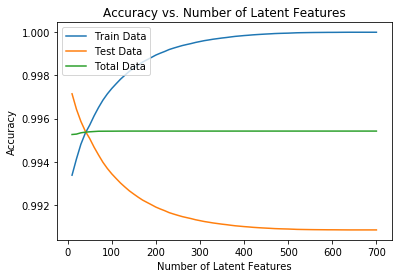

In [56]:
# Function to get common user and item indices
def get_prediction_idx(user_item_train, user_item_test):
    # Get the common users and items in both train and test datasets
    common_users = np.intersect1d(user_item_train.index, user_item_test.index)
    common_items = np.intersect1d(user_item_train.columns, user_item_test.columns)

    # Get the positional indices of common users and items
    user_idx = user_item_train.index.get_indexer(common_users)
    item_idx = user_item_train.columns.get_indexer(common_items)

    return common_users, user_idx, common_items, item_idx

# Define number of latent features to test
num_latent_feats = np.arange(10, 700+10, 10)
sum_errs_train = []
sum_errs_test = []
sum_errs_total = []

for k in num_latent_feats:
    # Restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

    # Take dot product - make predictions
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    # Compute error for each prediction to actual value for training data
    diffs_train = np.subtract(user_item_train, user_item_est)
    err_train = np.sum(np.abs(diffs_train.values))  # Using absolute values to ensure positive error
    sum_errs_train.append(err_train)

    # Get the common users and items between train and test
    com_users_ids, com_user_idx, com_arts_ids, com_arts_idx = get_prediction_idx(user_item_train, user_item_test)

    # Calculate difference between estimated user_item matrix from above and test_user_item_matrix
    test_est = pd.DataFrame(user_item_est)

    # Select only the relevant users and items for the test set and calculate the difference
    diffs_test = np.subtract(user_item_test.loc[com_users_ids, com_arts_ids], 
                             test_est.iloc[com_user_idx, com_arts_idx])

    # Sum up the error for test data (absolute values to avoid negative errors)
    err_test = np.sum(np.abs(diffs_test.values))
    sum_errs_test.append(err_test)
    
    # Calculate the total error (train + test)
    err_total = err_train + err_test
    sum_errs_total.append(err_total)

# Test outputs - final errors and latent features
#print(f"\nFinal number of latent features: {num_latent_feats}")
#print(f"Training errors: {sum_errs_train}")
#print(f"Test errors: {sum_errs_test}")
#print(f"Total errors: {sum_errs_total}")

# Plot the results
plt.clf()  # Clear plot to avoid overlaps
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train) / (user_item_train.shape[0] * user_item_train.shape[1]), label='Train Data')
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test) / (user_item_test.shape[0] * user_item_test.shape[1]), label='Test Data')

# Add the total line
plt.plot(num_latent_feats, 1 - np.array(sum_errs_total) / ((user_item_train.shape[0] * user_item_train.shape[1]) + 
                                                           (user_item_test.shape[0] * user_item_test.shape[1])), label='Total Data')

plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [57]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Create user-item matrix for training set
    user_item_train = df_train.groupby(['user_id', 'article_id'])['title'].count().unstack().fillna(0)
    
    # Create user-item matrix for test set
    user_item_test = df_test.groupby(['user_id', 'article_id'])['title'].count().unstack().fillna(0)
    
    # Get test user ids and article ids
    test_idx = df_test['user_id'].unique()
    test_arts = df_test['article_id'].unique()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [58]:
# Get the user_ids from the training and test sets
train_idx = user_item_train.index
test_idx = user_item_test.index

# Get the article_ids from the training and test sets
train_arts = user_item_train.columns
test_arts = user_item_test.columns

# Calculate how many users can we make predictions for in the test set
users_in_both_sets = len(np.intersect1d(test_idx, train_idx))
print(users_in_both_sets)

# Calculate how many users we cannot make predictions for
cold_start_users = len(test_idx) - users_in_both_sets
print(cold_start_users)

# Calculate how many articles can we make predictions for in the test set
articles_in_both_sets = len(np.intersect1d(test_arts, train_arts))
print(articles_in_both_sets)
# Calculate how many articles we cannot make predictions for
cold_start_articles = len(test_arts) - articles_in_both_sets
print(cold_start_articles)

20
662
574
0


In [59]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [60]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = svds(user_item_train, k=50)

In [61]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data


Final number of latent features: [ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360
 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540
 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700]
Training errors: [36345.0, 32187.0, 29058.0, 25776.0, 23170.0, 20522.0, 18283.0, 16588.0, 15167.0, 13759.0, 12385.0, 11171.0, 10103.0, 9245.0, 8540.0, 7906.0, 7232.0, 6550.0, 5942.0, 5427.0, 4943.0, 4508.0, 4060.0, 3680.0, 3353.0, 3066.0, 2844.0, 2609.0, 2387.0, 2194.0, 1976.0, 1795.0, 1615.0, 1482.0, 1379.0, 1265.0, 1123.0, 1014.0, 913.0, 843.0, 752.0, 652.0, 561.0, 498.0, 439.0, 372.0, 323.0, 292.0, 254.0, 227.0, 201.0, 176.0, 154.0, 126.0, 100.0, 72.0, 55.0, 45.0, 35.0, 25.0, 21.0, 20.0, 12.0, 4.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Test errors: [400.0, 404.0, 419.0, 434.0, 457.0, 457.0, 476.0, 480.0, 485.0, 491.0, 503.0, 505.0, 514.0, 522.0, 529.0, 539.0, 543.0, 548.0, 553.

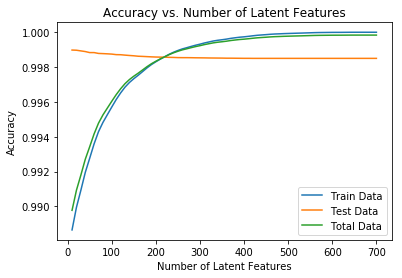

In [62]:
# Function to get common user and item indices
def get_prediction_idx(user_item_train, user_item_test):
    # Get the common users and items in both train and test datasets
    common_users = np.intersect1d(user_item_train.index, user_item_test.index)
    common_items = np.intersect1d(user_item_train.columns, user_item_test.columns)

    # Get the positional indices of common users and items
    user_idx = user_item_train.index.get_indexer(common_users)
    item_idx = user_item_train.columns.get_indexer(common_items)

    return common_users, user_idx, common_items, item_idx

# Step 1: Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

# Define number of latent features to test
num_latent_feats = np.arange(10, 700+10, 10)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # Step 2: Restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

    # Step 3: Take dot product - make predictions for user_item_train
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    # Step 4: Compute error for each prediction to actual value for training data
    diffs_train = np.subtract(user_item_train, user_item_est)
    err_train = np.sum(np.abs(diffs_train.values))  # Using absolute values to ensure positive error
    sum_errs_train.append(err_train)

    # Step 5: Get the common users and items between train and test
    com_users_ids, com_user_idx, com_arts_ids, com_arts_idx = get_prediction_idx(user_item_train, user_item_test)

    # Step 6: Calculate difference between estimated user_item matrix from above and test_user_item_matrix
    test_est = pd.DataFrame(user_item_est)

    # Step 7: Select only the relevant users and items for the test set and calculate the difference
    diffs_test = np.subtract(user_item_test.loc[com_users_ids, com_arts_ids], 
                             test_est.iloc[com_user_idx, com_arts_idx])

    # Step 8: Sum up the error for test data (absolute values to avoid negative errors)
    err_test = np.sum(np.abs(diffs_test.values))
    sum_errs_test.append(err_test)

# Test outputs - final errors and latent features
print(f"\nFinal number of latent features: {num_latent_feats}")
print(f"Training errors: {sum_errs_train}")
print(f"Test errors: {sum_errs_test}")

# Step 9: Plot the results
plt.clf()  # Clear plot to avoid overlaps
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train) / (user_item_train.shape[0] * user_item_train.shape[1]), label='Train Data')
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test) / (user_item_test.shape[0] * user_item_test.shape[1]), label='Test Data')

# Optionally add total error if needed
sum_errs_total = [train + test for train, test in zip(sum_errs_train, sum_errs_test)]
plt.plot(num_latent_feats, 1 - np.array(sum_errs_total) / ((user_item_train.shape[0] * user_item_train.shape[1]) + 
                                                           (user_item_test.shape[0] * user_item_test.shape[1])), label='Total Data')

plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])